In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/22 12:47:23 WARN Utils: Your hostname, hdilab-hdilabALIEN05 resolves to a loopback address: 127.0.1.1; using 172.21.136.110 instead (on interface enp3s0)
24/09/22 12:47:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/22 12:47:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/22 12:47:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [15]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Оставим только 300 самых популярных айтемов

In [16]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_items = logs.iloc[:300]['item_id'].tolist()

In [17]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (389735, 5)


Оставим информацию только о фичах юзеров и айтемов которые остались в логах

In [19]:
data.items = data.items[data.items['item_id'].isin(popular_items)]
users = set(data.ratings['user_id'].tolist())
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((6039, 5), (300, 3))

In [20]:
len(data.items['item_id'].unique()), len(data.ratings['item_id'].unique())

(300, 300)

In [21]:
dataset = MovielensBanditDataset(data)

22-Sep-24 13:01:14, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


22-Sep-24 13:01:19, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
22-Sep-24 13:01:20, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


fit started
predict started


100%|██████████| 389735/389735 [00:22<00:00, 17396.84it/s]


In [22]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 116921/116921 [00:06<00:00, 17037.68it/s]


272814
116921


In [23]:
log = bandit_feedback_train['log'].toPandas()
items = log['item_idx'].tolist()
pscores = log['pscore'].tolist()

In [24]:
item2pscore = [0 for _ in range(len(set(items)))]
for i in range(log.shape[0]):
    item2pscore[items[i]] = pscores[i]

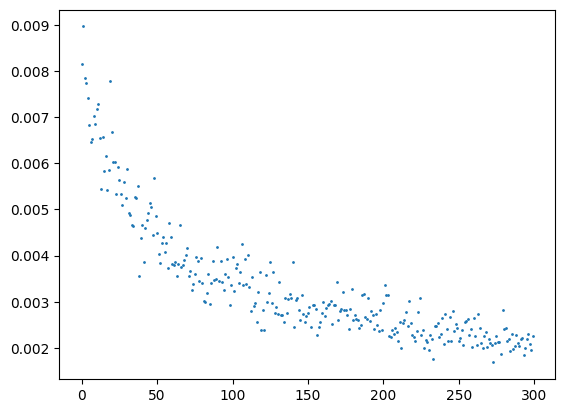

In [25]:
plt.scatter(np.arange(len(set(items))), item2pscore, s = 1)
plt.show()

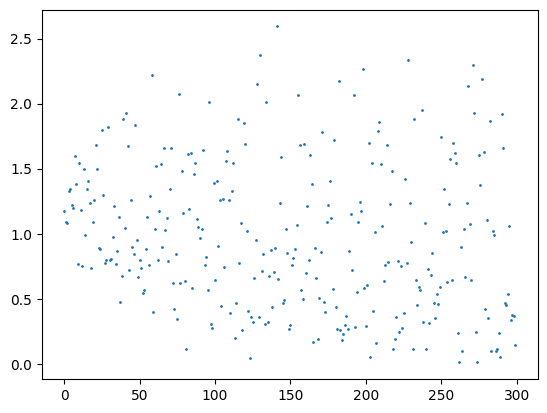

In [92]:
w2 = learner_action_dist_2[0][:, 0] / np.array(item2pscore)
plt.scatter(np.arange(len(set(items))), w2, s = 1)
plt.show()

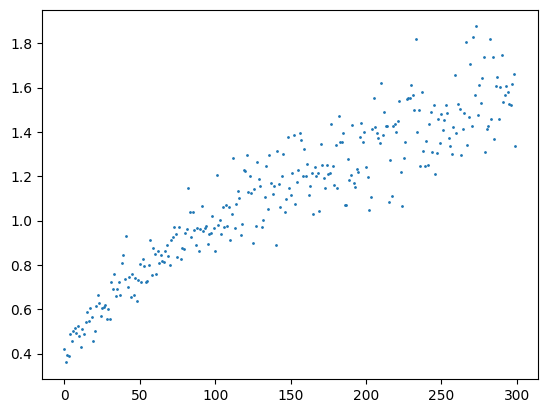

In [93]:
w3 = learner_action_dist_3[0][:, 0] / np.array(item2pscore)
plt.scatter(np.arange(len(set(items))), w3, s = 1)
plt.show()

In [27]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [28]:
#Define replay model
model_1 = UCB(exploration_coef = 0.01, sample = True, seed = 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2) #len_list is the number of predicted items per user
learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [31]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [32]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

# np.save('estimated_rewards_by_reg_model', estimated_rewards_by_reg_model)
# estimated_rewards_by_reg_model = np.load('estimated_rewards_by_reg_model.npy')

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [33]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j] = action_dist
    return all_action_dist

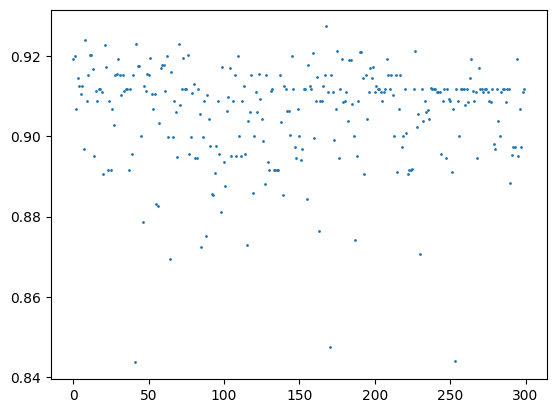

In [34]:
plt.scatter(np.arange(len(estimated_rewards_by_reg_model[0][:, 0])), estimated_rewards_by_reg_model[0][:, 0], s = 1)
plt.show()

In [35]:
#Predict distribution over actions: shape (n_rounds, n_actions)
import warnings
warnings.filterwarnings("ignore")

import time
start = time.time()
learner_action_dist_1 = get_dist(learner_1)
print(time.time() - start)

# np.save('learner_action_dist_1', learner_action_dist_1)
# learner_action_dist_1 = np.load('learner_action_dist_1.npy')

start = time.time()
learner_action_dist_2 = get_dist(learner_2)
print(time.time() - start)

# np.save('learner_action_dist_2', learner_action_dist_2)
# learner_action_dist_2 = np.load('learner_action_dist_2.npy')

start = time.time()
learner_action_dist_3 = get_dist(learner_3)
print(time.time() - start)

# np.save('learner_action_dist_3', learner_action_dist_3)
# learner_action_dist_3 = np.load('learner_action_dist_3.npy')

  0%|          | 0/390 [00:00<?, ?it/s]

100%|██████████| 390/390 [01:13<00:00,  5.31it/s]


73.37981367111206


100%|██████████| 233/233 [00:58<00:00,  4.02it/s]


58.06036686897278


100%|██████████| 390/390 [01:07<00:00,  5.82it/s]

67.06414794921875


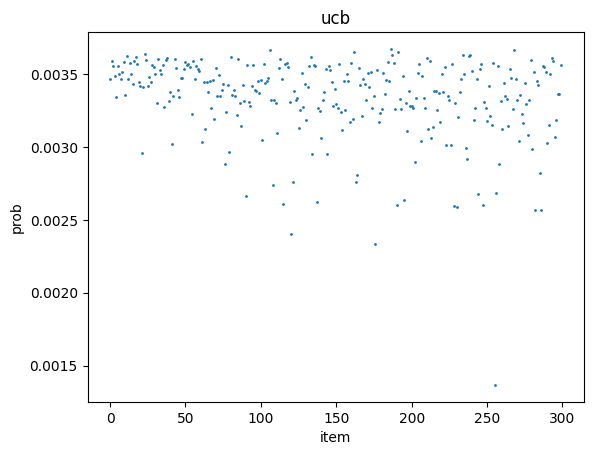

In [36]:
plt.title('ucb')
plt.xlabel('item')
plt.ylabel('prob')


plt.scatter(np.arange(len(learner_action_dist_1[0][:, 0])), learner_action_dist_1[0][:, 0], s = 1)
plt.show()

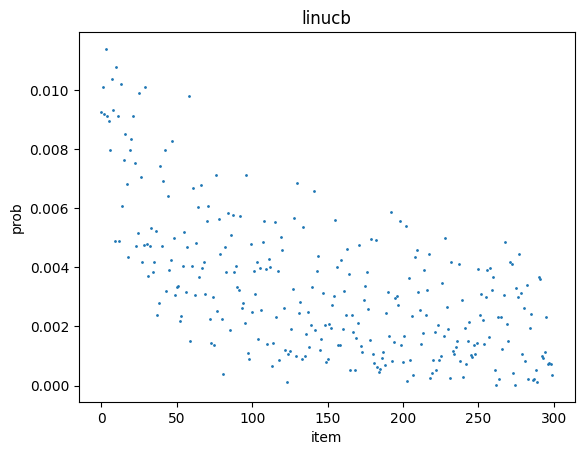

In [37]:
plt.title('linucb')
plt.xlabel('item')
plt.ylabel('prob')
plt.scatter(np.arange(len(learner_action_dist_2[0][:, 0])), learner_action_dist_2[0][:, 0], s = 1)
plt.show()

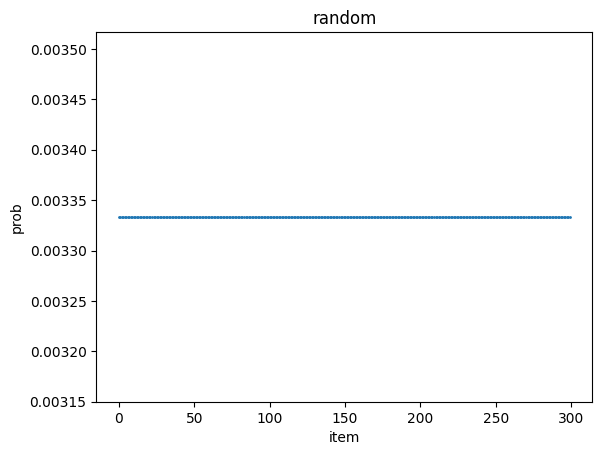

In [38]:
plt.title('random')
plt.xlabel('item')
plt.ylabel('prob')
plt.scatter(np.arange(len(learner_action_dist_3[0][:, 0])), learner_action_dist_3[0][:, 0], s = 1)
plt.show()

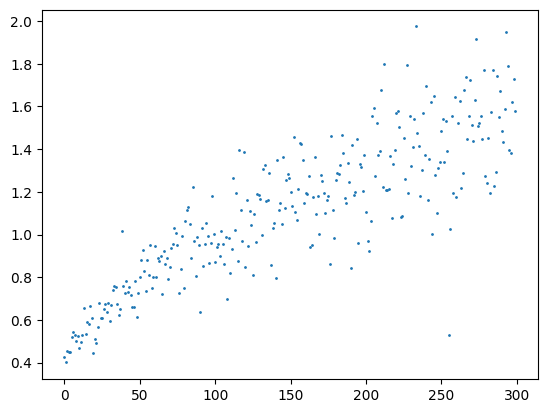

In [39]:
w1 = learner_action_dist_1[0][:, 0] / np.array(item2pscore)
plt.scatter(np.arange(len(set(items))), w1, s = 1)
plt.show()

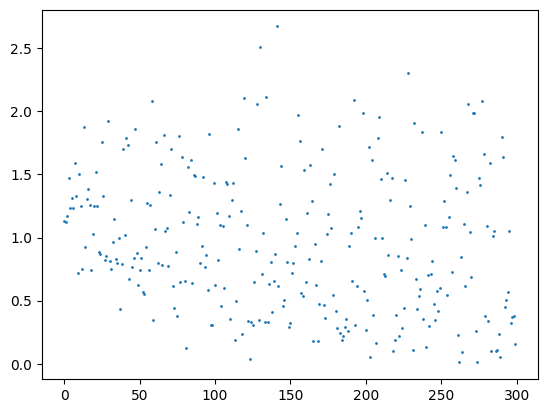

In [40]:
w2 = learner_action_dist_2[0][:, 0] / np.array(item2pscore)
plt.scatter(np.arange(len(set(items))), w2, s = 1)
plt.show()

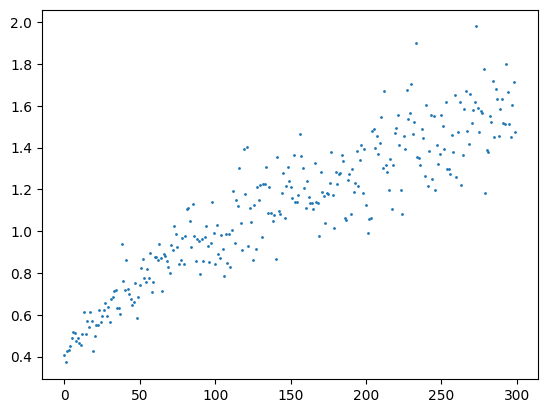

In [41]:
w3 = learner_action_dist_3[0][:, 0] / np.array(item2pscore)
plt.scatter(np.arange(len(set(items))), w3, s = 1)
plt.show()

In [ ]:
actions = bandit_feedback_test['action']
pscores = bandit_feedback_test['pscore']
rewards = bandit_feedback_test['reward'][actions]

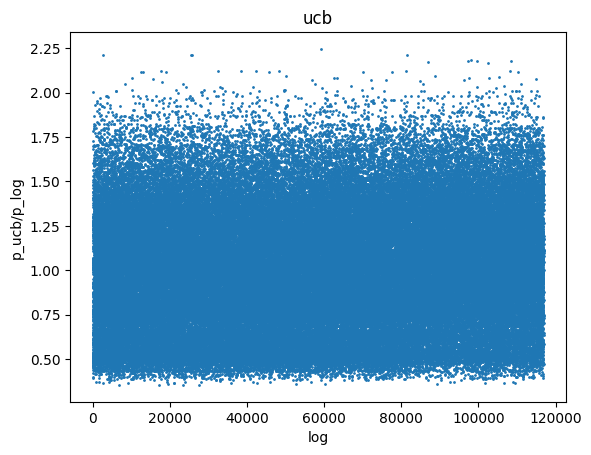

0.9106380376945685


In [64]:
plt.title('ucb')
plt.xlabel('log')
plt.ylabel('p_ucb/p_log')

plt.scatter(np.arange(actions.size), learner_action_dist_1[np.arange(actions.size), actions, 0]/pscores, s = 1)
plt.show()

ips = (rewards * learner_action_dist_1[np.arange(actions.size), actions, 0]/pscores).mean()
print(ips)

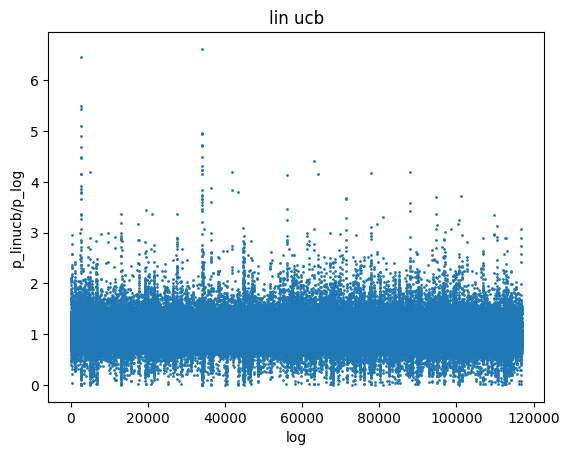

0.9295884095367614


In [65]:
plt.title('lin ucb')
plt.xlabel('log')
plt.ylabel('p_linucb/p_log')

plt.scatter(np.arange(actions.size), learner_action_dist_2[np.arange(actions.size), actions, 0]/pscores, s = 1)
plt.show()

ips = (rewards * learner_action_dist_2[np.arange(actions.size), actions, 0]/pscores).mean()
print(ips)

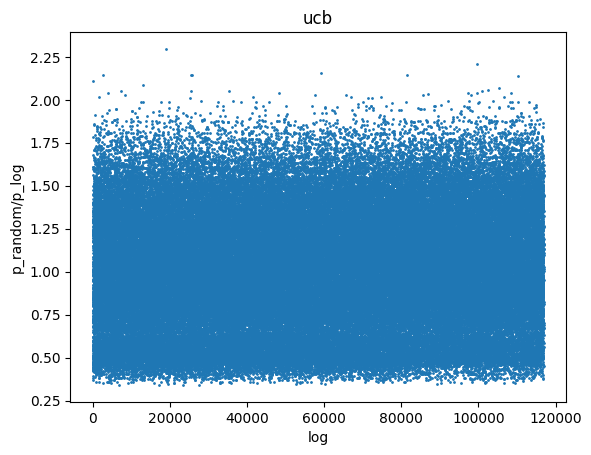

0.9137637357744253


In [66]:
plt.title('ucb')
plt.xlabel('log')
plt.ylabel('p_random/p_log')

plt.scatter(np.arange(actions.size), learner_action_dist_3[np.arange(actions.size), actions, 0]/pscores, s = 1)
plt.show()

ips = (rewards * learner_action_dist_3[np.arange(actions.size), actions, 0]/pscores).mean()
print(ips)

In [67]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 150000, 200000, 250000, 300000]:
    for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        
        action_dist = learner_action_dist[:n_size, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=100,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [68]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 10000 time:  0.1844019889831543
n_size = 20000 time:  0.2823817729949951
n_size = 30000 time:  0.316103458404541
n_size = 40000 time:  0.4962038993835449
n_size = 50000 time:  0.5288100242614746
n_size = 60000 time:  0.5719330310821533
n_size = 70000 time:  0.8820116519927979
n_size = 80000 time:  0.9453699588775635
n_size = 90000 time:  0.97186279296875
n_size = 100000 time:  1.0023388862609863
n_size = 116921 time:  1.1343615055084229


In [69]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 10000 time:  0.16834568977355957
n_size = 20000 time:  0.28212690353393555
n_size = 30000 time:  0.3149545192718506
n_size = 40000 time:  0.5130529403686523
n_size = 50000 time:  0.5291855335235596
n_size = 60000 time:  0.5719113349914551
n_size = 70000 time:  0.8822112083435059
n_size = 80000 time:  0.9566652774810791
n_size = 90000 time:  0.9865877628326416
n_size = 100000 time:  1.0340287685394287
n_size = 116921 time:  1.0968255996704102


In [70]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 10000 time:  0.1677415370941162
n_size = 20000 time:  0.2896418571472168
n_size = 30000 time:  0.3203616142272949
n_size = 40000 time:  0.5022881031036377
n_size = 50000 time:  0.5258333683013916
n_size = 60000 time:  0.5734314918518066
n_size = 70000 time:  0.8975582122802734
n_size = 80000 time:  0.9506700038909912
n_size = 90000 time:  0.9896602630615234
n_size = 100000 time:  1.0034675598144531
n_size = 116921 time:  1.0995454788208008


In [71]:
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

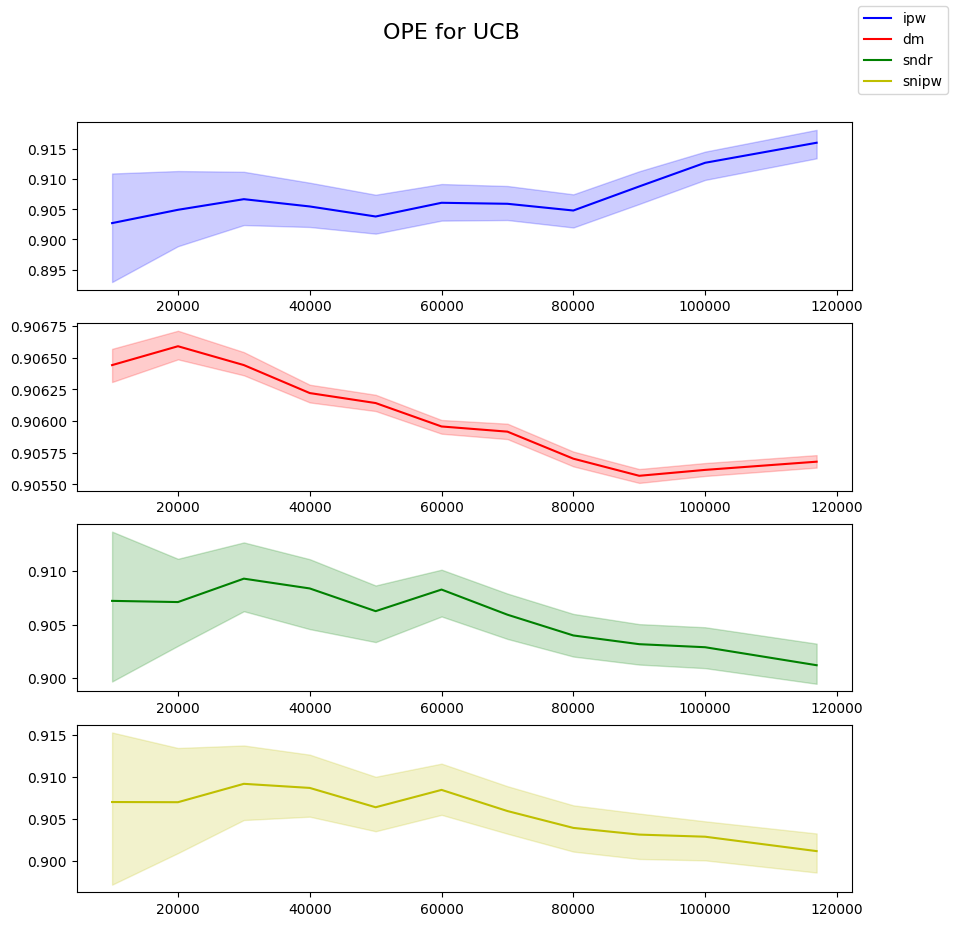

In [72]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

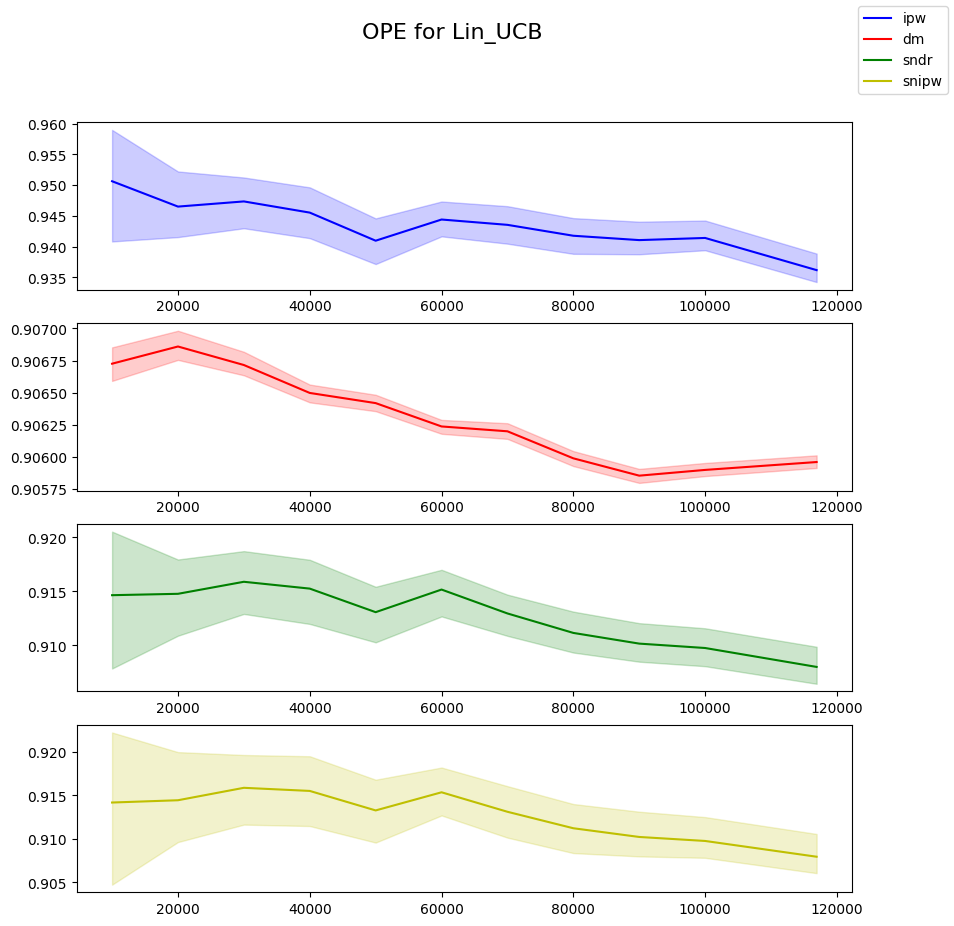

In [73]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

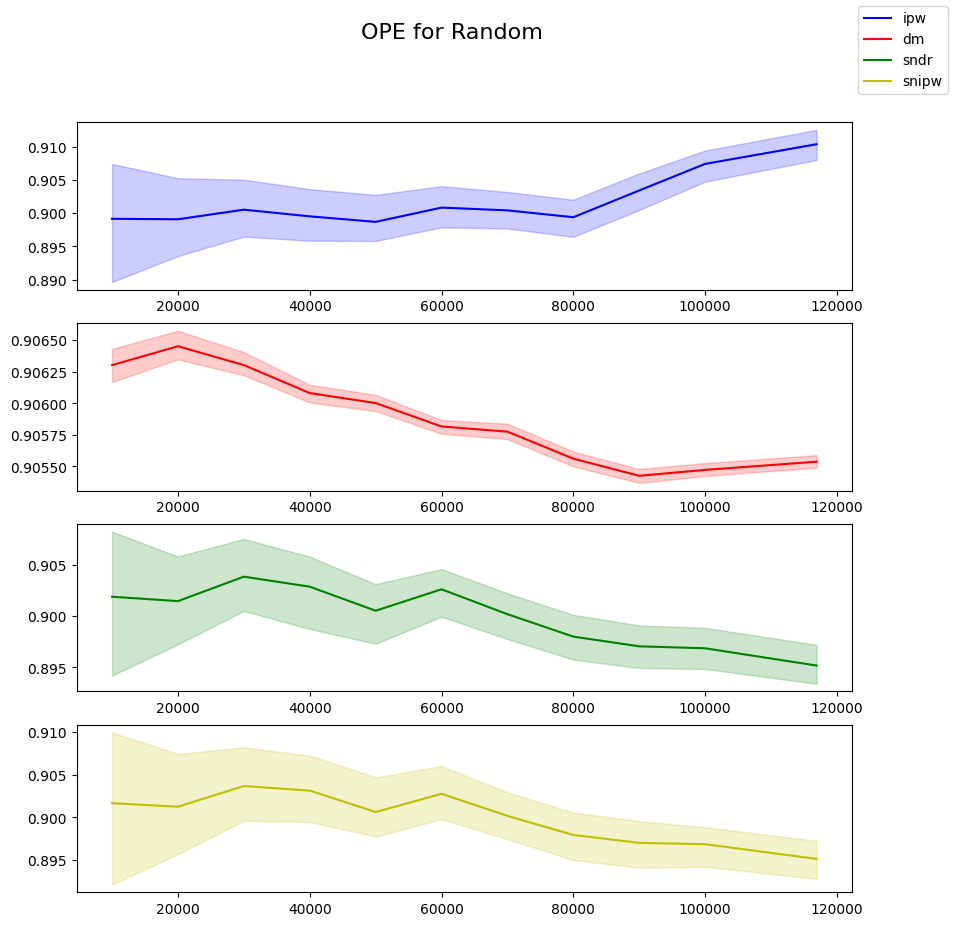

In [74]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [75]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 915.854, dm : 905.675, sndr : 901.114, snipw : 901.027


In [76]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 936.006, dm : 905.956, sndr : 907.919, snipw : 907.797


In [77]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 910.192, dm : 905.534, sndr : 895.066, snipw : 894.962


In [82]:
print("USB")
print(Vs_1[-1])
print("Lin USB")
print(Vs_2[-1])
print("Random")
print(Vs_3[-1])

USB
{'ipw': 0.9158536807727319, 'dm': 0.905674865022189, 'sndr': 0.9011141505891701, 'snipw': 0.9010273227190393}
Lin USB
{'ipw': 0.9360062760755563, 'dm': 0.9059563593077257, 'sndr': 0.9079188306325209, 'snipw': 0.9077973627886198}
Random
{'ipw': 0.9101918765951855, 'dm': 0.9055341906361211, 'sndr': 0.8950658454131722, 'snipw': 0.8949619073169025}


In [83]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              0.916014  0.905679  0.901207  0.901185
95.0% CI (lower)  0.913431  0.905632  0.899471  0.898644
95.0% CI (upper)  0.918144  0.905731  0.903225  0.903281
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.936158  0.905960  0.907992  0.907944
95.0% CI (lower)  0.934216  0.905914  0.906427  0.906061
95.0% CI (upper)  0.938852  0.906012  0.909863  0.910557
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.910369  0.905538  0.895170  0.895136
95.0% CI (lower)  0.907995  0.905491  0.893391  0.892801
95.0% CI (upper)  0.912520  0.905590  0.897187  0.897251


In [84]:
def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
    fig, ax = plt.subplots(4, figsize=(15, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i=0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

        ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

        ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        ax[i].set_title(name)
        
        i = i+1
    fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
    fig.legend()

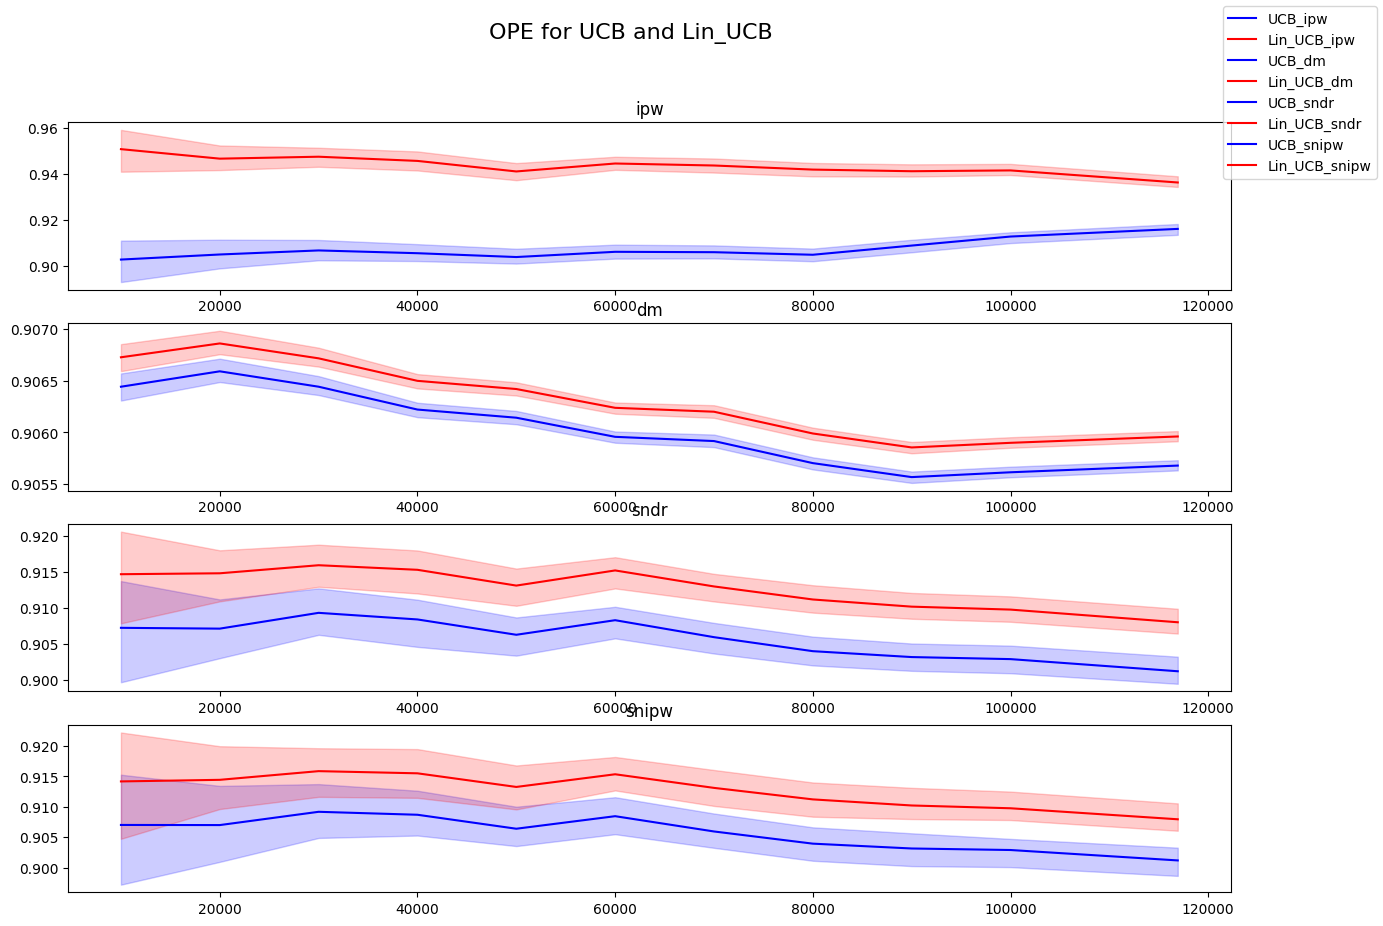

In [85]:
plot_res_two_politics(CIs_1, CIs_2, "UCB", "Lin_UCB")

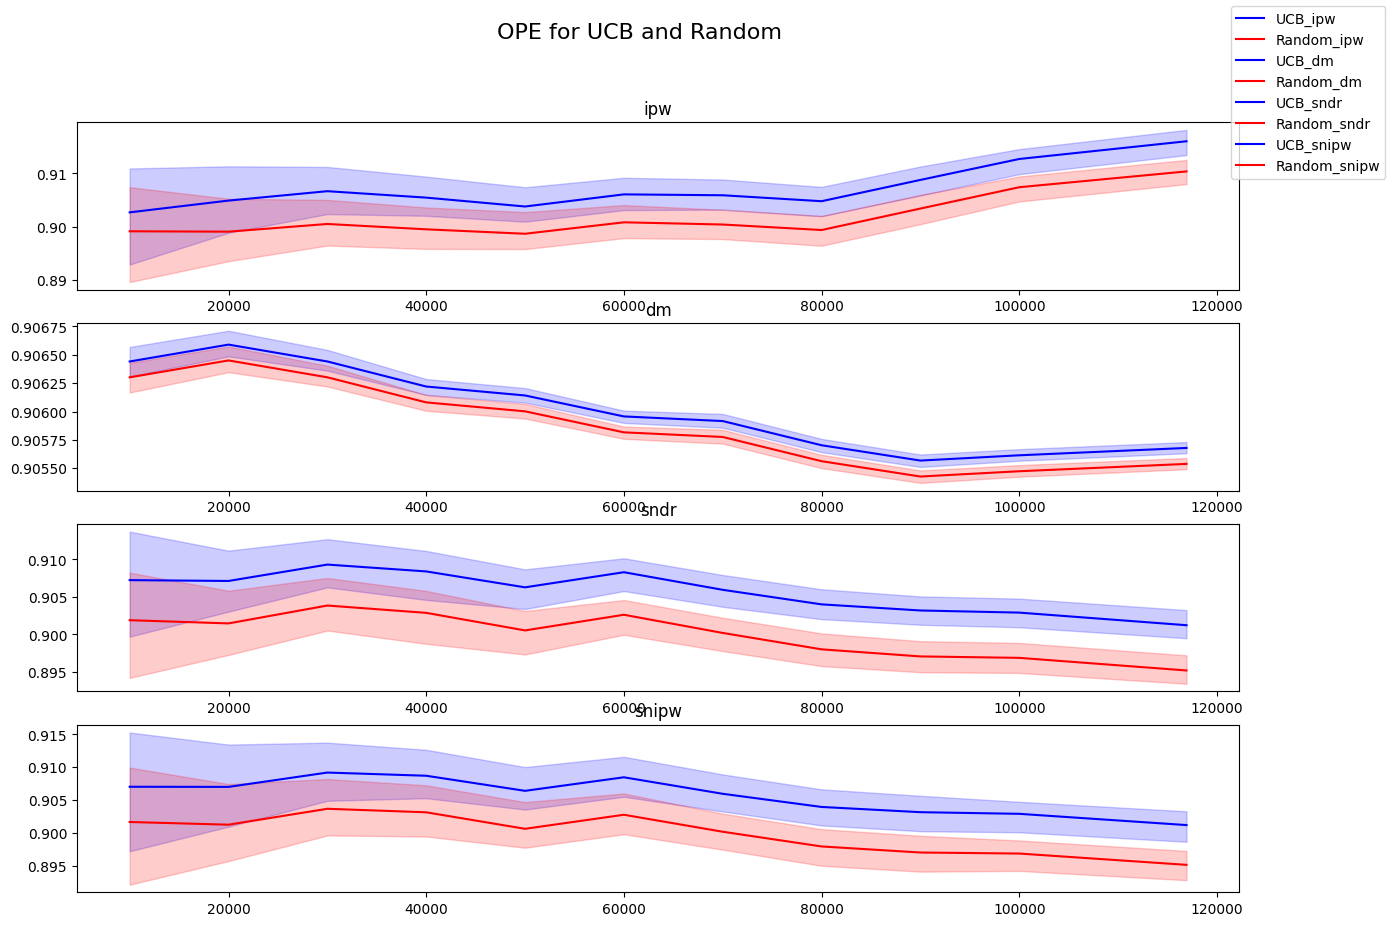

In [86]:
plot_res_two_politics(CIs_1, CIs_3, "UCB", "Random")

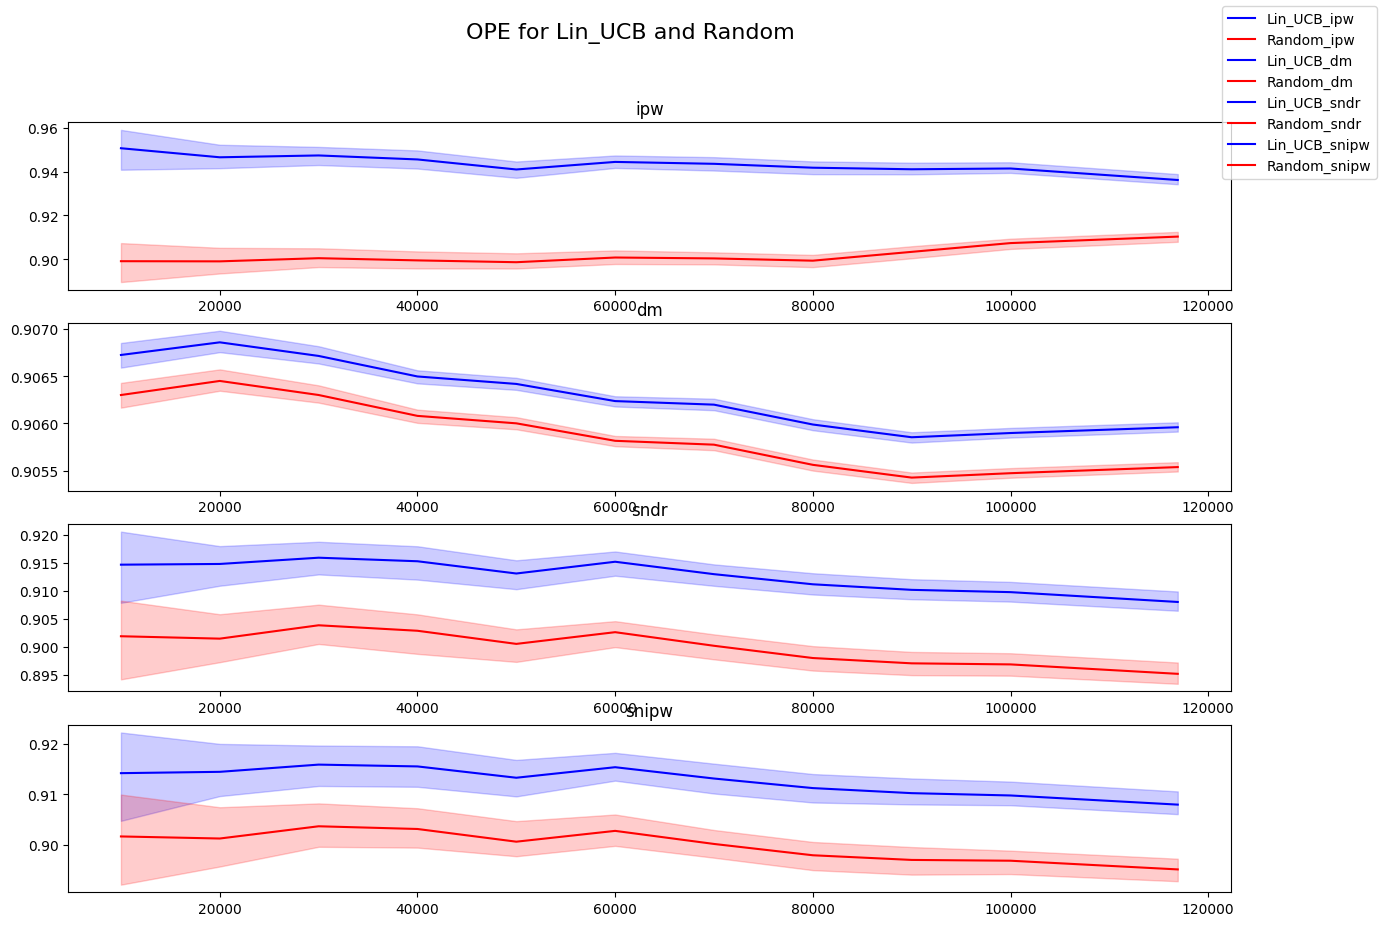

In [87]:
plot_res_two_politics(CIs_2, CIs_3, "Lin_UCB", "Random")

In [88]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw','dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

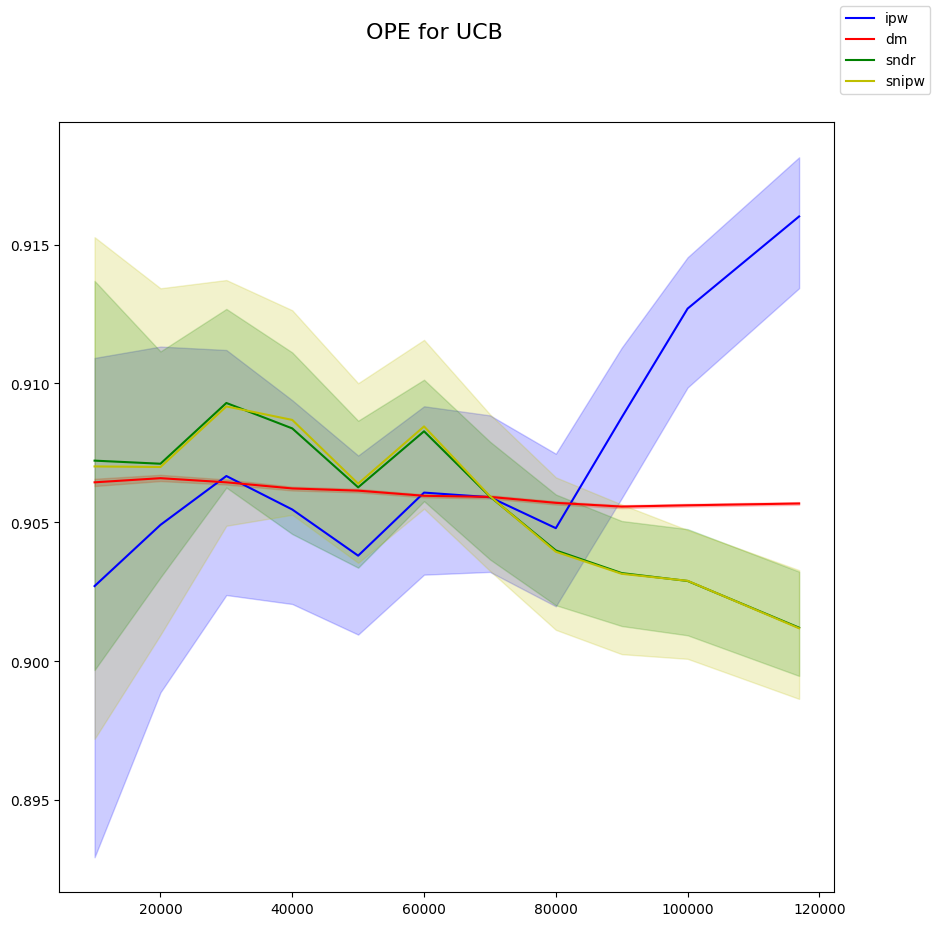

In [89]:
plot_join_res(Vs_1, CIs_1, 'UCB')

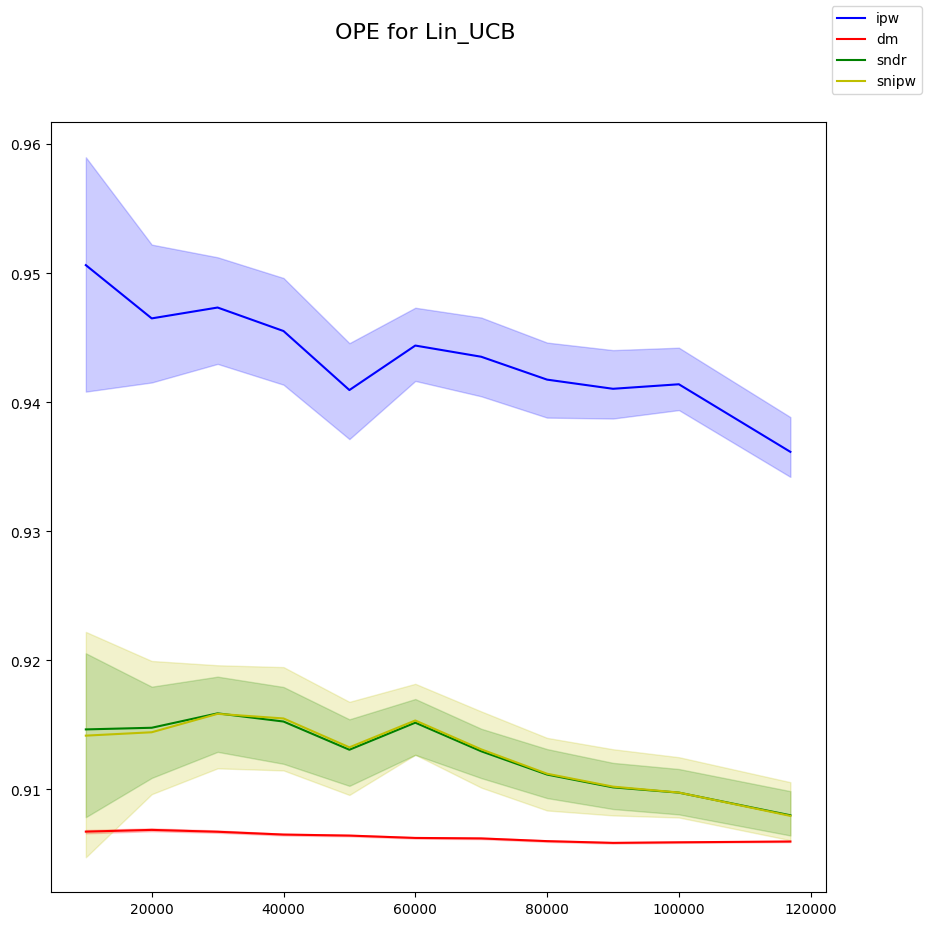

In [90]:
plot_join_res(Vs_2, CIs_2, 'Lin_UCB')

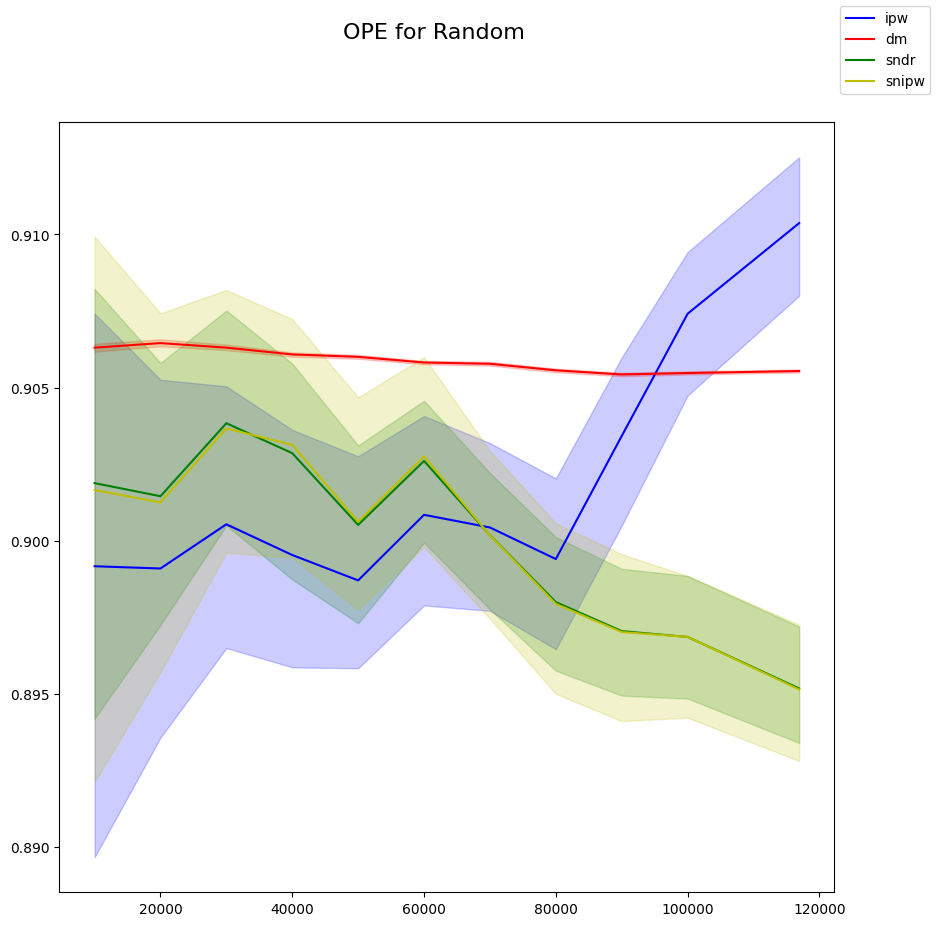

In [91]:
plot_join_res(Vs_3, CIs_3, 'Random')

In [94]:
import warnings
warnings.filterwarnings("ignore")

In [92]:
len(bandit_feedback_test['log'].toPandas()['user_idx'].unique())

2329

In [93]:
len(data.ratings['user_id'].unique())

6039

In [95]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 1))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 1))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 1))

Ucb


100%|██████████| 233/233 [00:46<00:00,  5.06it/s]                               


{'hr@1': 0.15338216286083584, 'mrr@1': 0.15338216286083584, 'ndcg@1': 0.013818580072899737, 'cov@1': 0.043333333333333335}
Lin_ucb


100%|██████████| 233/233 [00:21<00:00, 11.08it/s]


{'hr@1': 0.46402412753123656, 'mrr@1': 0.46402412753123656, 'ndcg@1': 0.04180508634413769, 'cov@1': 0.15666666666666668}
Random


100%|██████████| 233/233 [00:42<00:00,  5.43it/s]

{'hr@1': 0.17492460146488584, 'mrr@1': 0.17492460146488584, 'ndcg@1': 0.015759391880891274, 'cov@1': 1.0}


In [96]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 3))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 3))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 3))

Ucb


100%|██████████| 233/233 [00:43<00:00,  5.31it/s]


{'hr@3': 0.31968978888410166, 'mrr@3': 0.22368232083871892, 'ndcg@3': 0.029742590511875416, 'cov@3': 0.09333333333333334}
Lin_ucb


100%|██████████| 233/233 [00:20<00:00, 11.12it/s]


{'hr@3': 0.6742783283067644, 'mrr@3': 0.5583082004882952, 'ndcg@3': 0.08253079266332038, 'cov@3': 0.27666666666666667}
Random


100%|██████████| 233/233 [00:42<00:00,  5.49it/s]


{'hr@3': 0.3614821197759586, 'mrr@3': 0.25506247307195173, 'ndcg@3': 0.0322213055289446, 'cov@3': 1.0}


In [116]:
# ssh hdilab@172.21.136.110 -p 22